**Alice Cole Ethan**

Spring 2020

CS 443: Computational Neuroscience

Project 4: Motion estimation

In [432]:
import math
import numpy as np
import matplotlib.pyplot as plt

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Project 4: Motion estimation

The goal of this project is to build a "deep" six layer competitive network that estimates motion in videos.

We will focus on a motion decision making task: when you decode neural network activity when processing a noisy video of moving dots, can the net determine the statistically dominant direction of motion over time? These videos are challenging from a motion detection perspective: there are false frame-to-frame correlations in dot correspondence, detection algorithms/mechanisms suffer from the aperture problem, etc.

## Task 1) Motion discrimination task with random dot kinematograms

While you will test your motion network on complex displays with varying levels of dot coherence later on, as you build your network you will use a simple moving dot pattern for testing/debugging. The objective of this task is programmatically generating these **random dot kinematograms (RDKs)**.

- In `random_dot_stimulus`, implement `make_random_dot_stimulus` to make the simple dot test pattern videos.
- In `net_plots`, implement `plot_act_image_single` to plot/visualize/show the RDK videos.

In [433]:
from random_dot_stimulus import make_random_dot_stimulus

In [434]:
from net_plots import plot_act_image_single

### Test 1a. Noise-free RDKs

- Write test code below that embeds videos (animations) showing
    - Rightward motion (0 deg). Should match `rdk_nonoise_000.mov`. Should use parameter `dir_rc=(0, 1)`.
    - Northeast motion (45 deg) Should match `rdk_nonoise_045.mov` Should use parameter `dir_rc=(-1, 1)`.
    - Downward motion (270 deg) Should match `rdk_nonoise_270.mov` Should use parameter `dir_rc=(1, 0))`.

You should use default parameters.

In [283]:
np.random.seed(0)
n_frames = 30

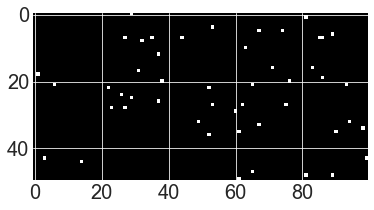

In [284]:
right_motion = make_random_dot_stimulus(n_frames, dir_rc=(0, 1))
plot_act_image_single(right_motion)

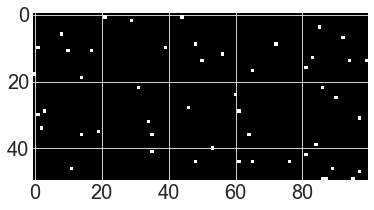

In [285]:
northeast_motion = make_random_dot_stimulus(n_frames, dir_rc=(-1, 1))
plot_act_image_single(northeast_motion)

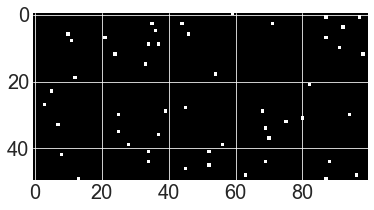

In [286]:
down_motion = make_random_dot_stimulus(n_frames, dir_rc=(1, 0))
plot_act_image_single(down_motion)

### Test 1b. Test with noise

- Write test code below that embeds videos (animations) showing rightward motion (0 deg) with different levels of noise:
    - 10% Noise. Should match `rdk_noise_10.mov`
    - 50% Noise. Should match `rdk_noise_50.mov`
    - 80% Noise. Should match `rdk_noise_80.mov`

You should use default parameters.

In [287]:
np.random.seed(0)
n_frames = 30

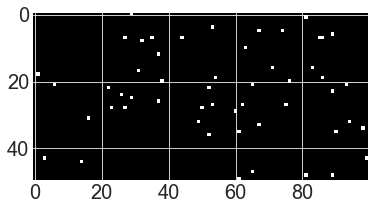

In [288]:
noise10 = make_random_dot_stimulus(n_frames, dir_rc=(0, 1), noise_prop=0.1)
plot_act_image_single(noise10)

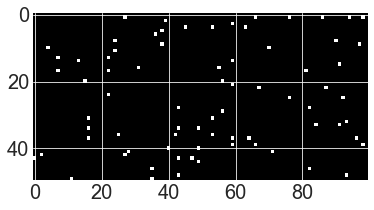

In [289]:
noise50 = make_random_dot_stimulus(n_frames, dir_rc=(0, 1), noise_prop=0.5)
plot_act_image_single(noise50)

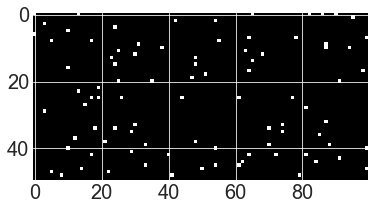

In [290]:
noise80 = make_random_dot_stimulus(n_frames, dir_rc=(0, 1), noise_prop=0.8)
plot_act_image_single(noise80)

## Task 2) Implement motion detection layers of neural network (Layers 1-2)

Now you are ready to start building the neural network!

The instructions below guide you through the progress of progressively building the network level-by-level to help with debugging.

For example, you will build Level 1 first and test it, then build Level 2 and test Levels 1 and 2 working together, etc. You will implement and test helper functions related to each layer as you go.

### 2a. Implement preliminary network methods

Implement the following methods in `motion.py` in the `MotionNet` class.

- Constructor
- `get_input(t)`. Get the appropriate external input signal frame at the current time step `t`.

In [435]:
from motion import MotionNet

#### Test: `get_input`

In [308]:
dt = 0.1
n_dirs = 8

test_net = MotionNet(dt,
                     n_dirs,
                     lvl1_params=None,
                     lv1_hgate_params=None,
                     do_lvl2=False,
                     do_lvl3=False,
                     do_lvl4=False,
                     do_lvl5=False,
                     do_lvl6=False)
np.random.seed(0)
test_video = np.random.random(size=(3, 2, 2))
test_net.inputs = test_video
print(f'Frame at t=0 is\n{test_net.get_input(0)}\nand should be\n[[0.549 0.715]\n [0.603 0.545]]')
print(f'Frame at t=1 is\n{test_net.get_input(1)}\nand should be\n[[0.549 0.715]\n [0.603 0.545]]')
print(f'Frame at t=2 is\n{test_net.get_input(2)}\nand should be\n[[0.549 0.715]\n [0.603 0.545]]')
print(f'Frame at t=9 is\n{test_net.get_input(9)}\nand should be\n[[0.549 0.715]\n [0.603 0.545]]')
print(f'\nFrame at t=10 is\n{test_net.get_input(10)}\nand should be\n[[0.424 0.646]\n [0.438 0.892]]')
print(f'Frame at t=11 is\n{test_net.get_input(11)}\nand should be\n[[0.424 0.646]\n [0.438 0.892]]')
print(f'Frame at t=19 is\n{test_net.get_input(19)}\nand should be\n[[0.424 0.646]\n [0.438 0.892]]')
print(f'\nFrame at t=20 is\n{test_net.get_input(20)}\nand should be\n[[0.964 0.383]\n [0.792 0.529]]')

Frame at t=0 is
[[0.549 0.715]
 [0.603 0.545]]
and should be
[[0.549 0.715]
 [0.603 0.545]]
Frame at t=1 is
[[0.549 0.715]
 [0.603 0.545]]
and should be
[[0.549 0.715]
 [0.603 0.545]]
Frame at t=2 is
[[0.549 0.715]
 [0.603 0.545]]
and should be
[[0.549 0.715]
 [0.603 0.545]]
Frame at t=9 is
[[0.549 0.715]
 [0.603 0.545]]
and should be
[[0.549 0.715]
 [0.603 0.545]]

Frame at t=10 is
[[0.424 0.646]
 [0.438 0.892]]
and should be
[[0.424 0.646]
 [0.438 0.892]]
Frame at t=11 is
[[0.424 0.646]
 [0.438 0.892]]
and should be
[[0.424 0.646]
 [0.438 0.892]]
Frame at t=19 is
[[0.424 0.646]
 [0.438 0.892]]
and should be
[[0.424 0.646]
 [0.438 0.892]]

Frame at t=20 is
[[0.964 0.383]
 [0.792 0.529]]
and should be
[[0.964 0.383]
 [0.792 0.529]]


### 2b. Layer 1: Non-directional transient cells

Implement the following methods that are used to simulate the network on an input video, now only starting with Layer 1: Non-directional transient cells.

- `simulate(inputs)`. Starts a simulation and have the network process the video (e.g. RDK). Initializes the network data structures then computes the network activity over time. 
- `initialize(n_steps, height, width)`. Instantiates each of the network data structures to hold network activity and layer output signals (i.e. initializes all variables declared in constructor in sections *Layer activity placeholders* and *Layer output activity placeholders*). Because all the cell activity data structures need to know properties about the input (#frames, height, and width), `initialize` is called when you call `simulate` on a particular video.
    - For now, only instantiate Layer 1 related variables (see constructor for a list).
- `update_net(t)`. Solve for all the cell populations activation in all the layers at the current time based on the previous time(s) and derivatives — numerical integration (e.g. via Euler's Method).
- `d_non_dir_transient_cells(t)`. Compute the change in the Level 1 cells: Non-directional transient cells.

#### (i) Simulate non-directional transient cells

Write test code in the below cell to simulate the noise-free rightward motion RDK video (`test_rdk_0`).
- Limit the number of frames to 10 (this is just a quick debugging test).
- Remember to toggle off all layers except Level 1 (in constructor) (not so important now that you only have one layer, but stuff you add later might make break this cell).
- Parameter values are up to you (but see the suggested parameter file for layer 1 if you need help). Tune by plotting and comparing against video for expected dynamics.
    - I have placed some code below showing how to use the parameter specifying classes. Their only purpose is to group parameters together for cells in each layer (like in a struct). That way, you don't have to define functions with long parameter lists. Replace the `None`s with parameters of your choice.
    - If you get overflow errors in the numerical integation, it could mean that your cell inverse time constant (`tau`) and/or your integration time step is too large.

In [436]:
from motion import KernelParams, LayerParams, HGateParams

In [437]:
# Set up input
np.random.seed(0)
right_motion = make_random_dot_stimulus(n_frames=10, dir_rc=(0, 1))
# Set up parameters
lvl1_params = LayerParams(tau=1, A=1)
lvl1_hgate_params = HGateParams(tau=1, K=50)

# Create and simulate network
net = MotionNet(dt=0.1, n_dirs=8, lvl1_params=lvl1_params, lv1_hgate_params=lvl1_hgate_params, do_lvl2=False, do_lvl3=False)
net.simulate(right_motion)

#### (ii) Test: Layer 1: non-directional transient cells

- In the notebook cell below, compute the Level 1 output signal (Non-directional transient cells: `y`) using the simulated activations from the cell above (i). Use an output threshold here of 0 at all the network time steps.
    - Note that I am using `dt = 0.1` when generating the forthcoming videos. This may or may not work for your parameters (and that's ok if it doesn't!). If you use a smaller timestep you can either plot all frames, or if this is too slow looking, you can just skip frames. For example, if you use `dt = 0.01` you can just plot every 10th time step to match the video pace below.
    - Note: `np.maximum` is good to know about. `np.max` probably won't do what you want.
- Plot the Non-directional transient cells (`y`) over time and make sure that it looks like the video `right_test_level1.mov` before moving on.

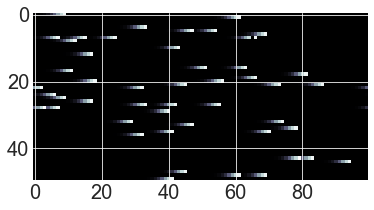

In [438]:
# Define y, the layer 1 output activation
y = np.maximum(net.x*net.z - 0, 0)

plot_act_image_single(y)

### 2c. Layer 2: Directional transient cells

#### (i) Implement Layer 2 helper functions

It will be helpful to have these function available and tested before implementing the layer. Implement each one-by-one then check your work via the test code below.

- `get_opponent_direction(dir)`. Given the direction index `dir`, return the index of the opponent direction (180 deg away).
- `make_inhib_dir_shift_map` in `motion.py`. Needed in motion detection / nulling inhibition. Maps each motion direction index (0, ..., 7) to a tuple indicating the row/col offsets needed to "take a step" in the direction of the opponent motion direction. For example a cell that prefers northeast motion (+45 deg) (index = 1) has an opponent motion direction of southwest (+225 deg) (index = 5). The shifts therefore are (1, -1) (i.e. step down 1 row, then step left one column). In this case, the key/value entry in the dictionary would be `1 -> (1, -1)`.
- `vector_sum_plot` in `net_plots.py`. This will allow you to visualize neurons tuned to different motion directions in an intuitive fashion (i.e. as vectors). 
- `decode_direction(act, t, thres=0)`. Applies an activation threshold (at time `t`) to 2D spatial arrays of direction cells. Then it decodes how much activation there is to each motion direction across the entire visual field in a simple way: sum of all the activity at every spatial position (i.e. how much evidence is there that things are globally moving in each of these 8 motion directions?).

**Equation for vector sum:**

$$U_{ij} = \sum_{d=1}^{\text{nDirs}} A_{dij}cos \left ( \frac{2\pi d}{\text{nDirs}}\right )$$
$$V_{ij} = \sum_{d=1}^{\text{nDirs}} A_{dij}sin \left ( \frac{2\pi d}{\text{nDirs}}\right )$$

where $A_{dij}$ is the network activation for a cell tuned to direction $d$ with receptive field positioned at location $(i,j)$. In these equations, the angles are assumed to be in radians.

*Side note:* Taking the vector sum in this way is a neural decoding approach called **population vector decoding.**

#### (ii) Test: `get_opponent_direction(dir)`

In [316]:
dt = 0.1
n_dirs = 8

test_net = MotionNet(dt,
                     n_dirs,
                     lvl1_params=None,
                     lv1_hgate_params=None,
                     do_lvl2=False,
                     do_lvl3=False,
                     do_lvl4=False,
                     do_lvl5=False,
                     do_lvl6=False)

opp_inds = np.zeros(n_dirs)
for d in range(len(opp_inds)):
    opp_inds[d] = test_net.get_opponent_direction(d)
print(f'Your opponent indices are {opp_inds}\nand should be             [4. 5. 6. 7. 0. 1. 2. 3.]')

Your opponent indices are [4. 5. 6. 7. 0. 1. 2. 3.]
and should be             [4. 5. 6. 7. 0. 1. 2. 3.]


#### (iii) Test: `make_inhib_dir_shift_map`

In [317]:
dt = 0.1
n_dirs = 8

test_net = MotionNet(dt,
                     n_dirs,
                     lvl1_params=None,
                     lv1_hgate_params=None,
                     do_lvl2=False,
                     do_lvl3=False,
                     do_lvl4=False,
                     do_lvl5=False,
                     do_lvl6=False)
inhib_dir_map = test_net.make_inhib_dir_shift_map(n_dirs)
print(f'Direction indices: {list(inhib_dir_map.keys())}')
print(f'Opponent shifts: {list(inhib_dir_map.values())}')
print('You should get:')
print('Direction indices: [0, 1, 2, 3, 4, 5, 6, 7]')
print('Opponent shifts: [(0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1)]')

Direction indices: [0, 1, 2, 3, 4, 5, 6, 7]
Opponent shifts: [(0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1)]
You should get:
Direction indices: [0, 1, 2, 3, 4, 5, 6, 7]
Opponent shifts: [(0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1)]


#### (iv) Test: `vector_sum_plot`

The expected output of the below test:

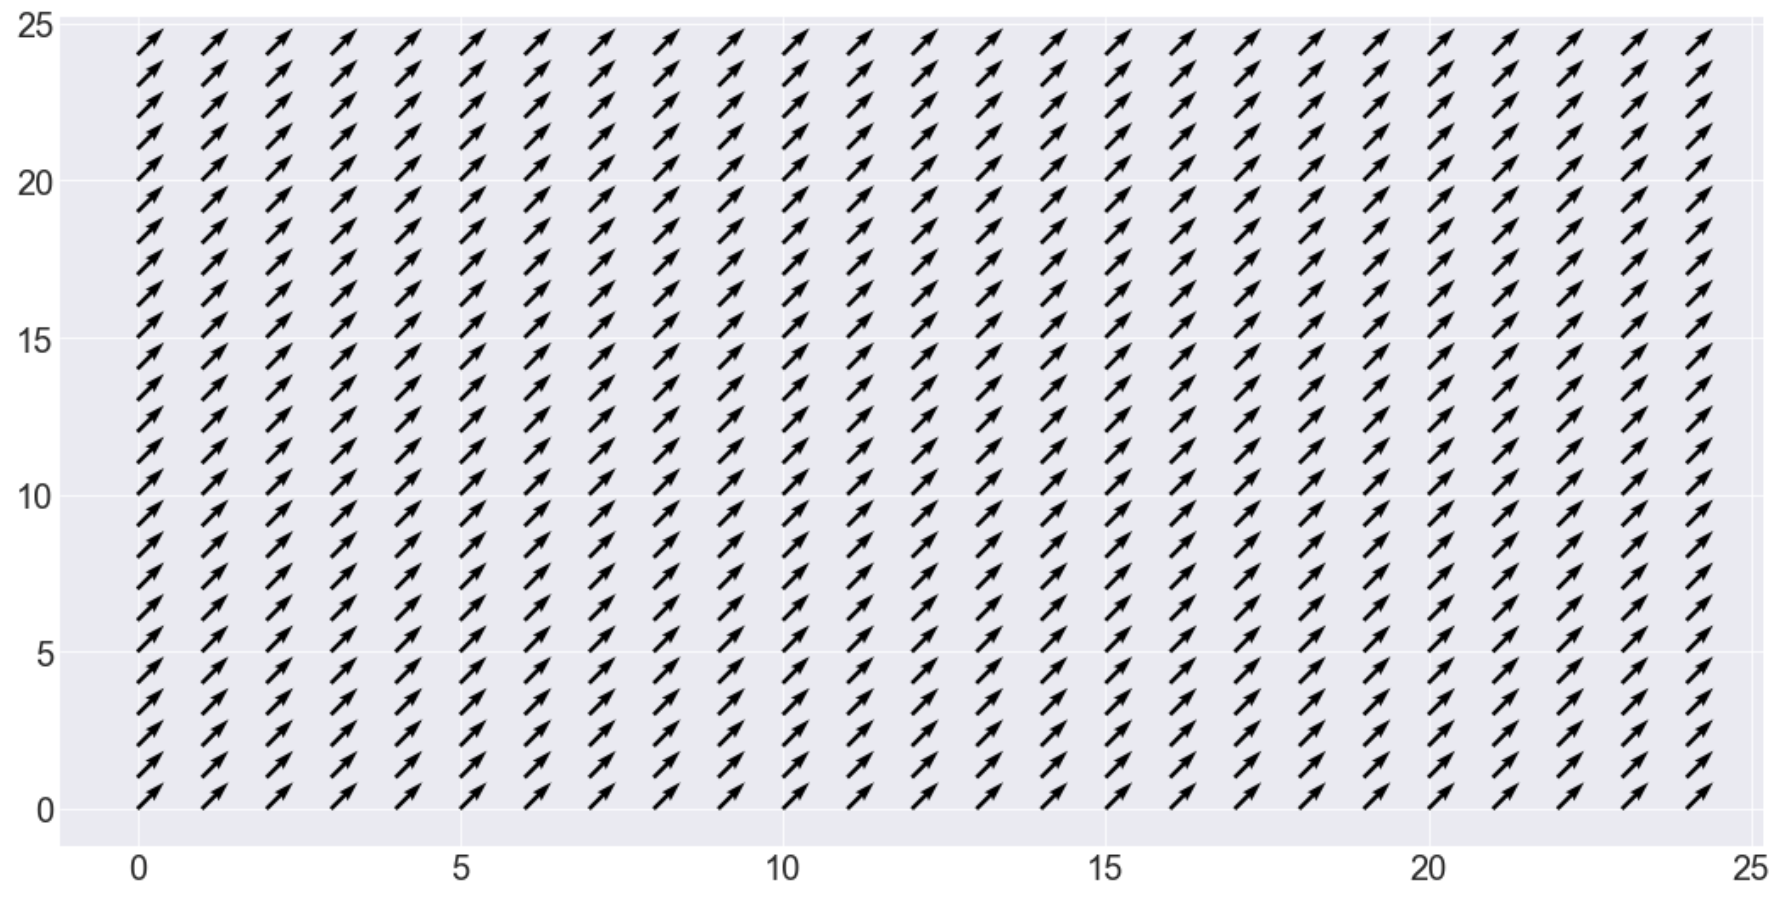

In [318]:
from net_plots import vector_sum_plot

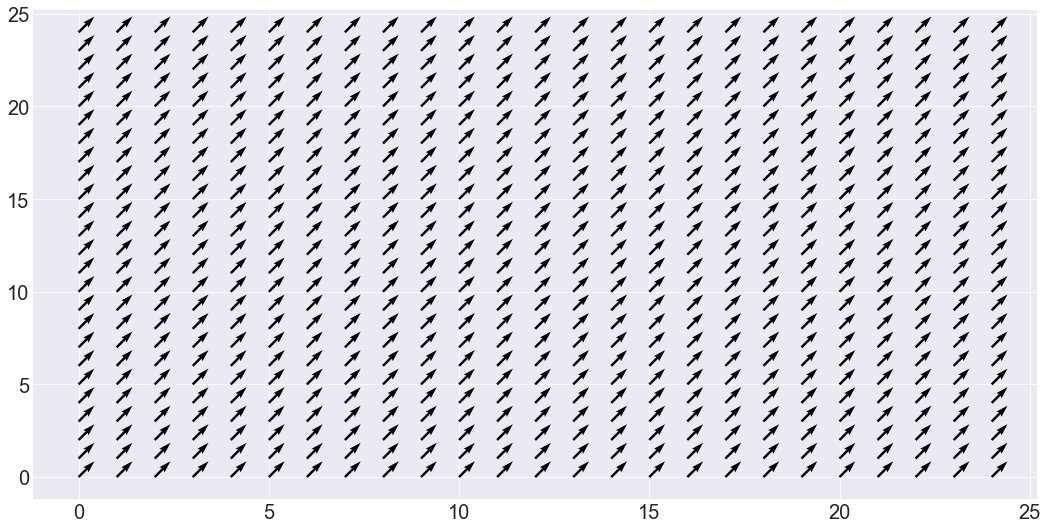

In [319]:
test_act = np.zeros([8, 25, 25])
test_act[1] = 1.0
vector_sum_plot(test_act)

#### (v) Test `decode_direction`

In [320]:
dt = 0.1
n_dirs = 8

test_net = MotionNet(dt,
                     n_dirs,
                     lvl1_params=None,
                     lv1_hgate_params=None,
                     do_lvl2=False,
                     do_lvl3=False,
                     do_lvl4=False,
                     do_lvl5=False,
                     do_lvl6=False)
np.random.seed(0)
test_act = np.random.random(size=(7, 8, 60, 60))
decoded = test_net.decode_direction(test_act, t=3, thres=0.1)
print(f'Your decoded evidence for each direction is\n{decoded}\nand should be\n[1461.99  1454.352 1483.547 1465.416 1489.279 1458.49  1479.127 1467.786]')

Your decoded evidence for each direction is
[1461.99  1454.352 1483.547 1465.416 1489.279 1458.49  1479.127 1467.786]
and should be
[1461.99  1454.352 1483.547 1465.416 1489.279 1458.49  1479.127 1467.786]


#### (vi) Implement and test Layer 2 directional transient cells

- Implement `d_dir_transient_cells`.
- Update `update_net` to integrate cell activity in Layer 2 (remember to put your code in a boolean if statement).
- In the cell below, simulate the noise-free rightward motion RDK video (`test_rdk_0`).
    -  Remember to turn on network layers 1 and 2.
    - Remember to define parameter objects and pick parameters for the Layer 2 directional transient cells and the interneurons
- Run the direction decode test below.
- In the cell below, rectify the directional transient cells.
- Plot the activation of the rectified output of all directions using `plot_act_image_grid`. Compare for consistency to `right_test_level2_grid.mov`.
    - Note that I am plotting starting at time step 9 to the end in steps of 10 with `dt = 0.1`.
    - *Please ignore the drifting of the placement of the second row of plots. I'm not about to launch a career as a YouTuber.*
- Plot the rectified directional transient cells using your vector sum plot. Compare for consistency with `right_test_level2_vectors.mov`.

In [323]:
# Set up input
np.random.seed(0)
right_motion = make_random_dot_stimulus(n_frames=10, dir_rc=(0, 1))
# Define parameters
lvl1_params = LayerParams(tau=1, A=1)
lvl1_hgate_params = HGateParams(tau=1, K=50)
lvl2_inter_params = LayerParams(tau=1, excit_g=10, inhib_g=40)
lvl2_params = LayerParams(tau=4, excit_g=10, inhib_g=40, output_thres=0.2)
# Simulate net
net = MotionNet(dt=0.1, 
                n_dirs=8, 
                lvl1_params=lvl1_params, 
                lv1_hgate_params=lvl1_hgate_params, 
                lvl2_inter_params=lvl2_inter_params, 
                lvl2_params=lvl2_params,
                do_lvl3=False,
                do_lvl4=False,
                do_lvl5=False,
                do_lvl6=False)
net.simulate(right_motion)
# Compute layer 2 output activation
e_out = net.dir_trans_out

print(e_out.shape)

(100, 8, 50, 100)


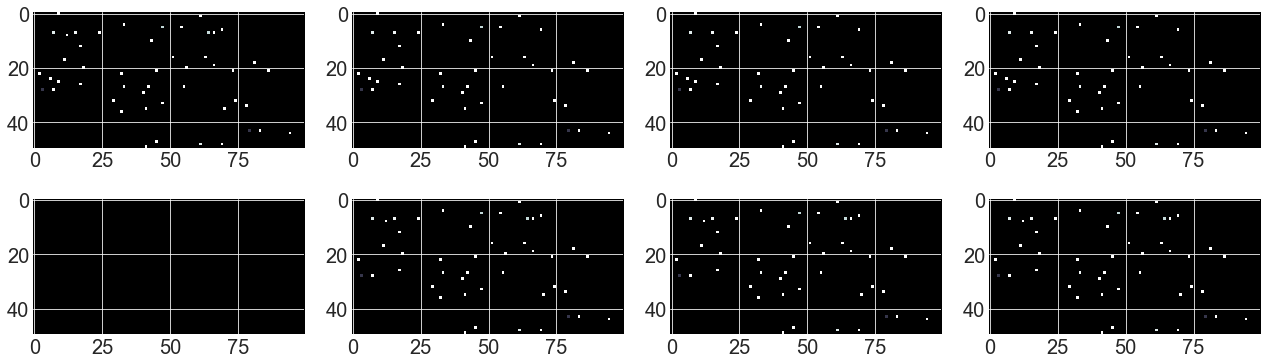

In [324]:
# Your grid of image plots of the layer 2 direction cells output over time
# print(e_out.shape)
from net_plots import plot_act_image_grid
plot_act_image_grid(e_out[::10], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))

#### Test: Decoded directional transient directions

**IMPORTANT NOTE:** Your exact values **WILL** differ and thats ok (due to parameter choices and different implementation decisions). You simply want to get rough qualitative agreement (*i.e. max value in index 0, others except the null direction should be close*).

In [325]:
print(net.decode_direction(net.dir_trans_inter_cells, -100))
print(net.decode_direction(net.dir_trans_cells, -1))
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.dir_trans_cells, -1)}\nand should roughly look like\n[8.219 8.055 7.726 7.726 0.    7.947 7.89  8.017]')

[4.9 4.9 4.9 4.9 4.9 4.9 4.9 4.9]
[31.196 29.752 30.025 30.142  0.518 30.773 30.615 30.359]
Your decoded evidence for each direction at the end of the simulation is
[31.196 29.752 30.025 30.142  0.518 30.773 30.615 30.359]
and should roughly look like
[8.219 8.055 7.726 7.726 0.    7.947 7.89  8.017]


In [326]:
from net_plots import vector_sum_plot

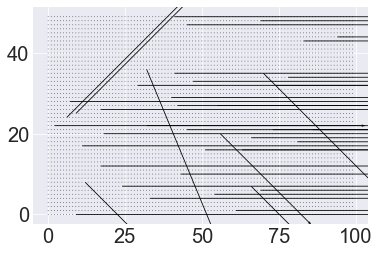

In [327]:
# Your vector sum plot of the layer 2 output over time
vector_sum_plot(e_out, figSz=(18, 9), pause=0.01)

#### (vii) Layer 2 questions

**Questions:**
1. Why does a slower timescale inhibitory interneuron lead to better motion detection?

## Task 3) Convolution kernels

Beginning with Layer 3, network layers perform convolution on the layer below to get their excitatory/inhibitory inputs (convolutional `netIn`). The convolution kernels are either **isotropic Gaussians** (the usual 2D Gaussian that is a symmetric circular blob) or **anisotropic Gaussians** (Gaussian elongated/stretched out in a chosen direction).

Implement and test both types of kernels in `filters.py` (`iso_gauss`, `aniso_gauss`) before diving into the neural network.

- Implement isotropic Gaussian filter (`iso_gauss`).
- Implement anisotropic Gaussian filter (`aniso_gauss`).
- Implement `plot_act_image_grid` in `net_plots.py` to visualize them.

In [6]:
import filters

In [7]:
from net_plots import plot_act_image_grid

### 3a. Test isotropic Gaussian filters

We will need plain isotropic Gaussians and those that have shifted/offset centers. So we will be testing both. 

- Write code below to generate 9 15x15 isotropic Gaussians with $\sigma$ = 5 and offsets: `[(-3, -3), (-3, 0), (-3, 3), (0, -3), (0, 0), (0, 3), (3, -3), (3, 0), (3, 3)]`. You should get:

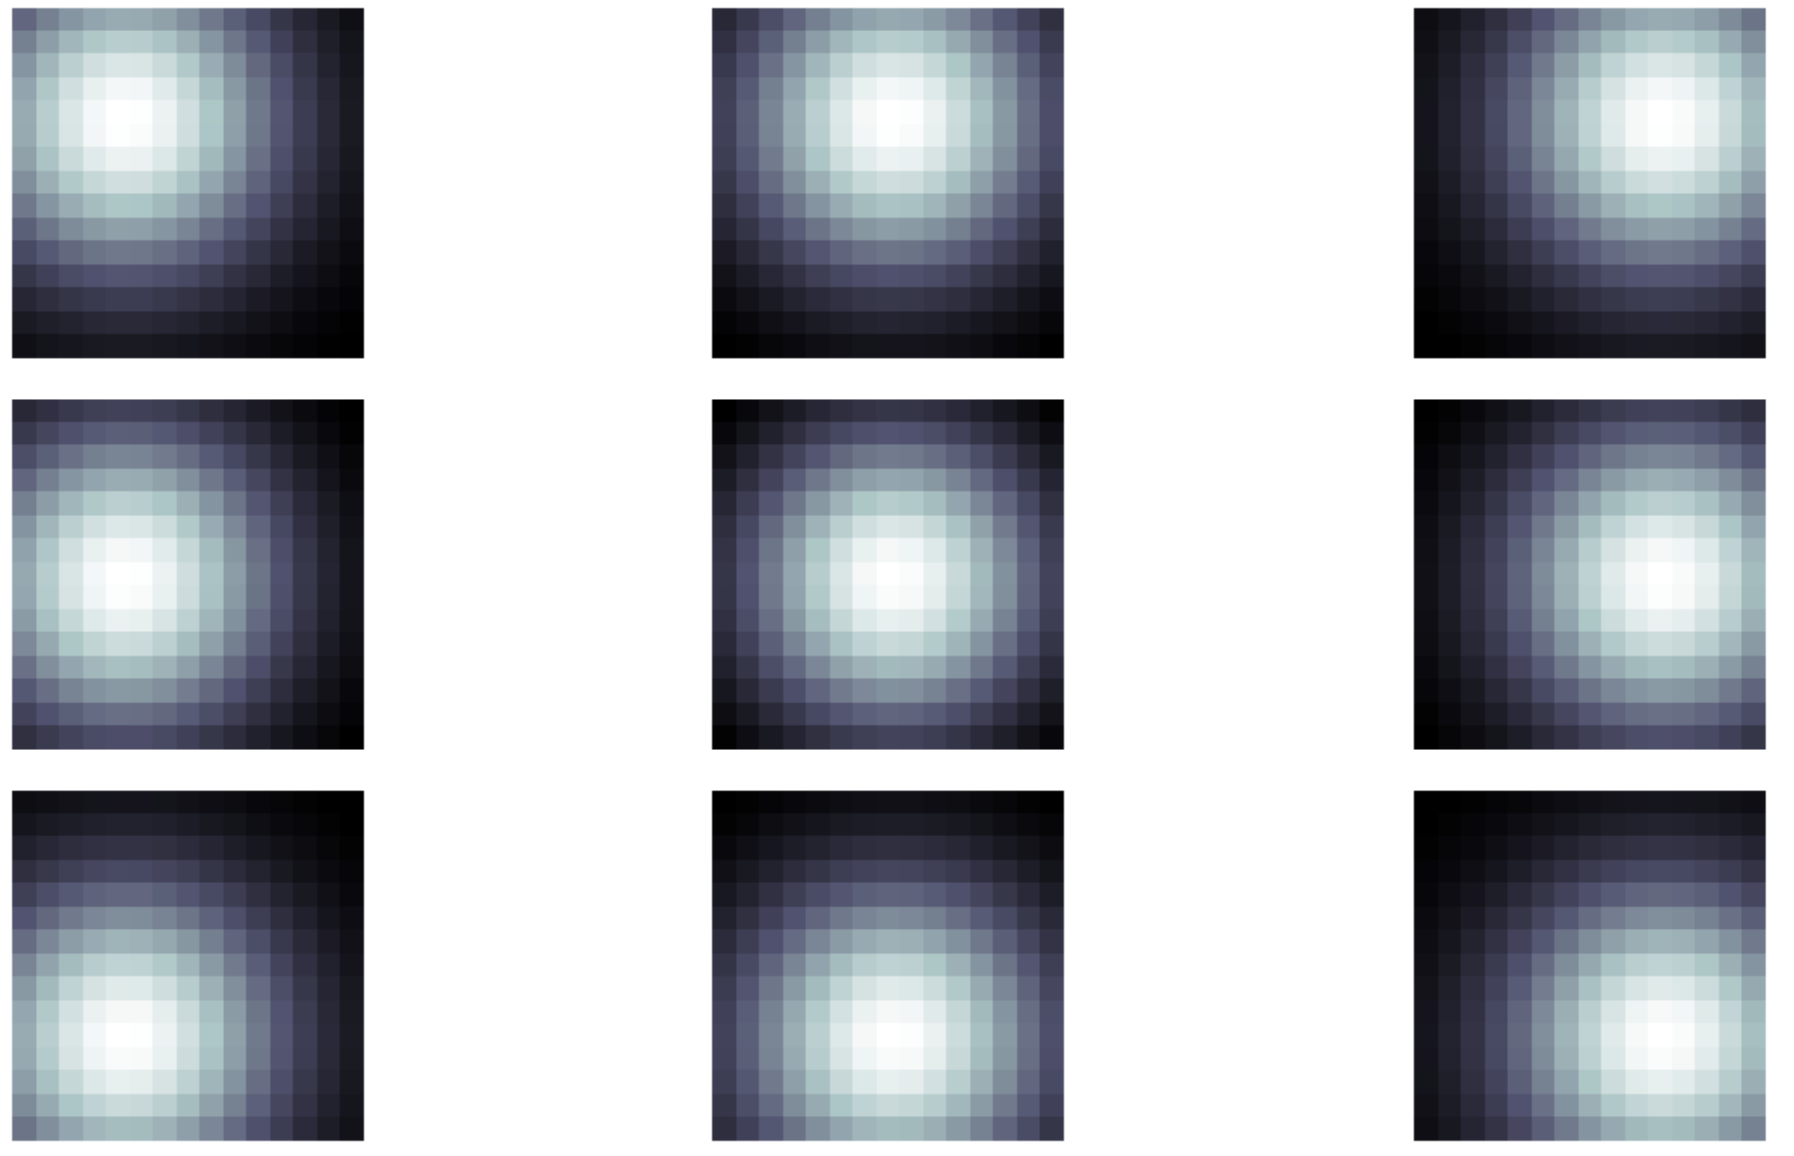

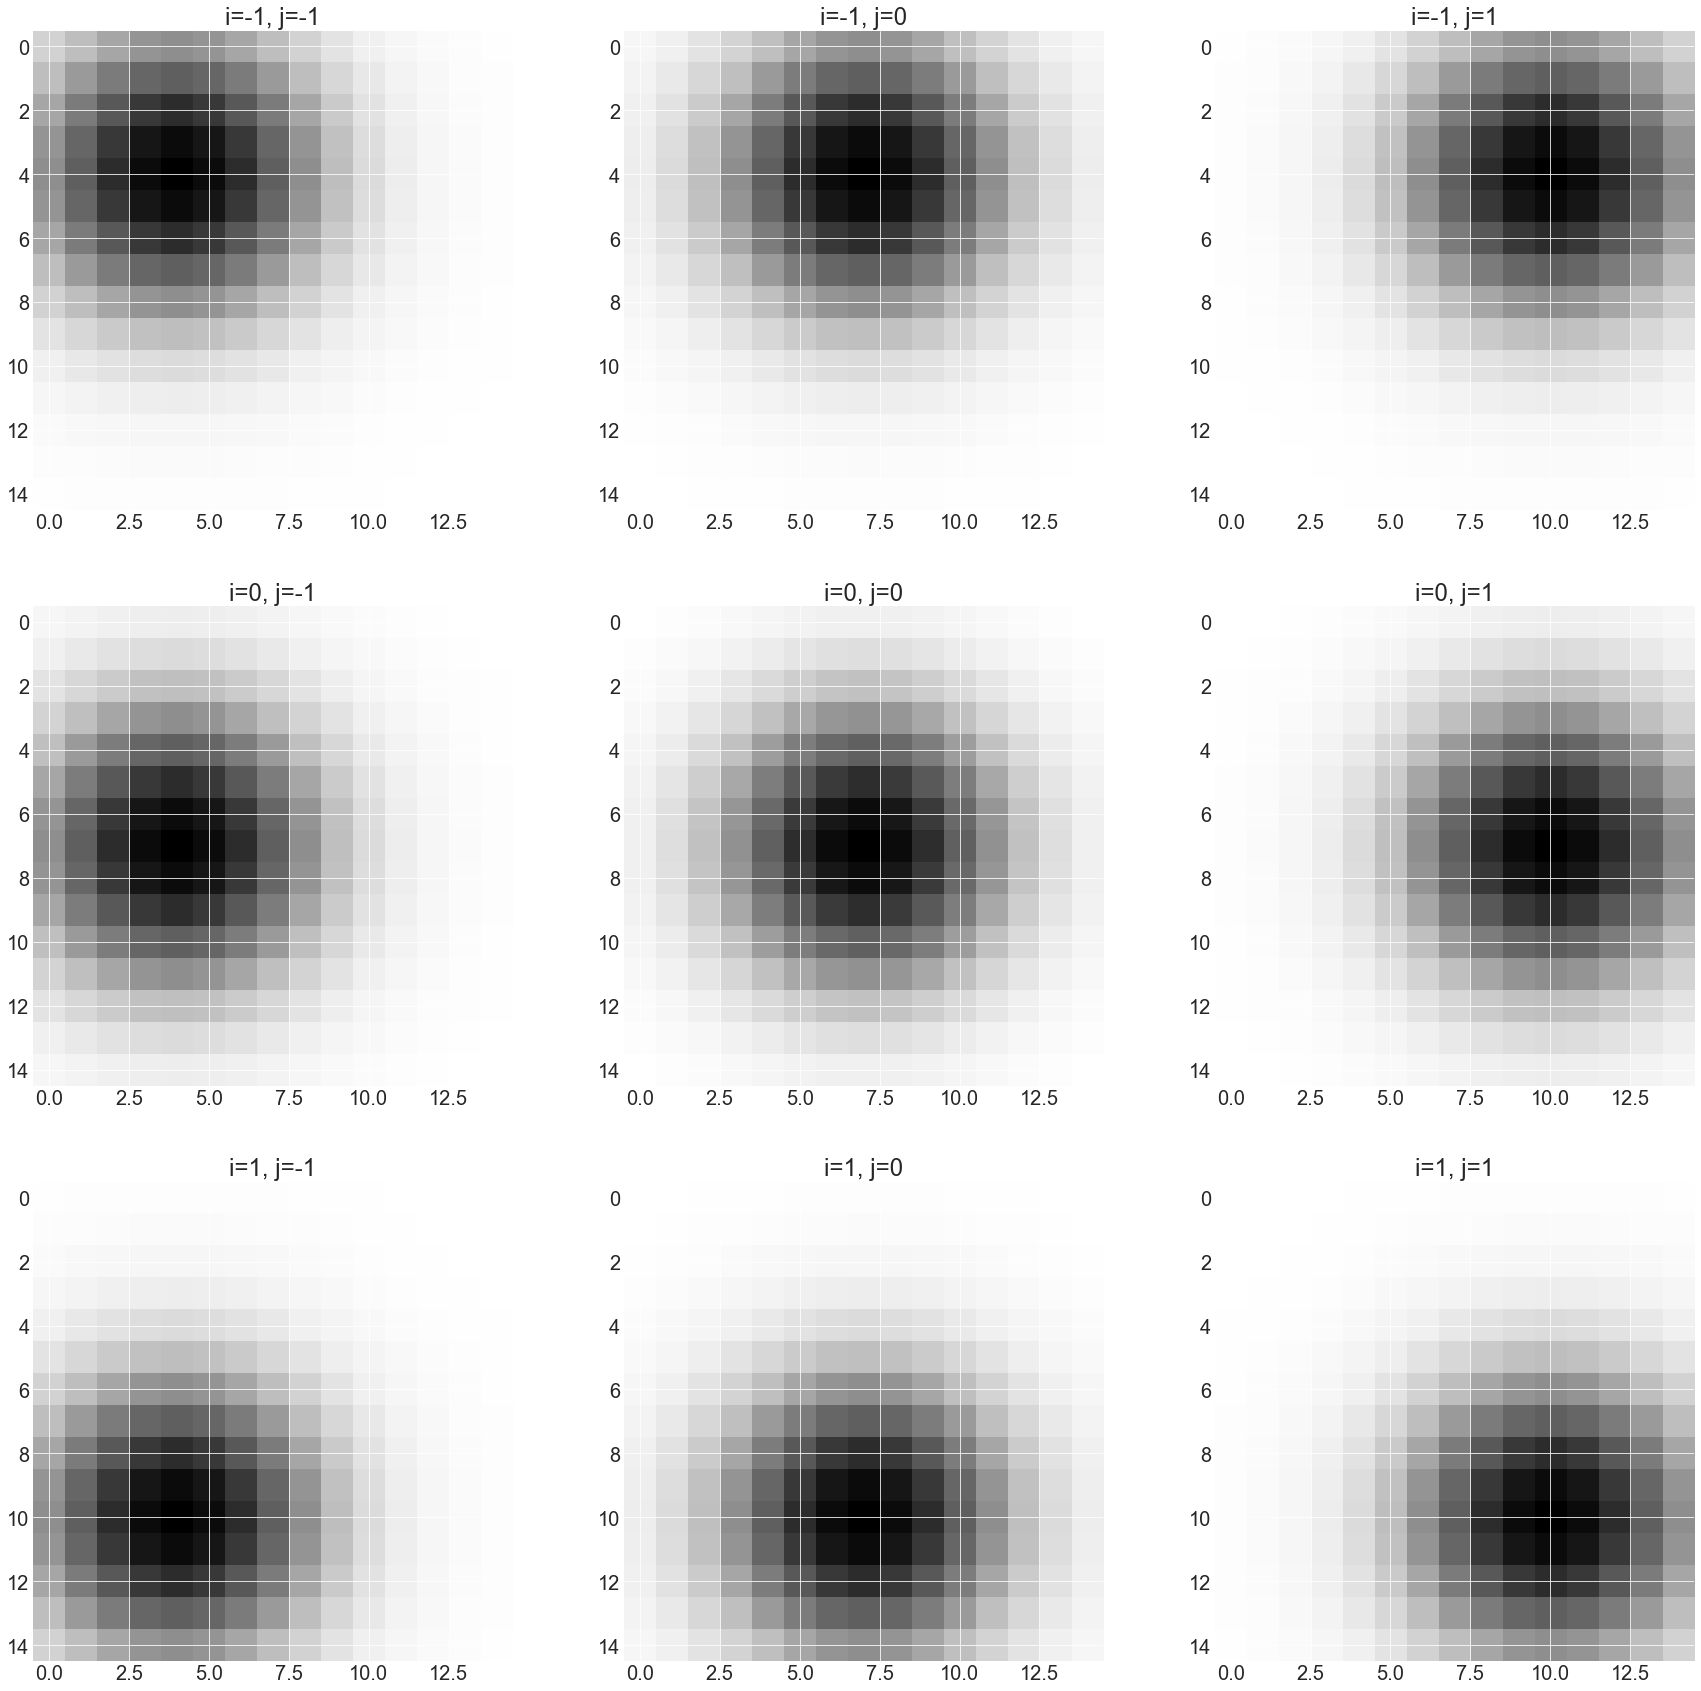

In [29]:
fig, axs = plt.subplots(3, 3, figsize=(30,30))
for i in range(-1, 2):
    for j in range(-1, 2):
        g = filters.iso_gauss(sz=(15, 15), sigma=5, offset=(i*3, j*3))
        axs[i+1, j+1].imshow(g)
        axs[i+1, j+1].set_title("i="+str(i)+", "+ "j="+str(j))

### 3b. Test anisotropic Gaussian filters

- Write code below to generate 8 15x15 anisotropic Gaussians (in 360/8 = 45 deg steps for the orientations) with default parameter values. You should get (*yes the 2nd row is redundant, but it is a good test of your function to make sure you get the same results in the range 180-360 deg*):

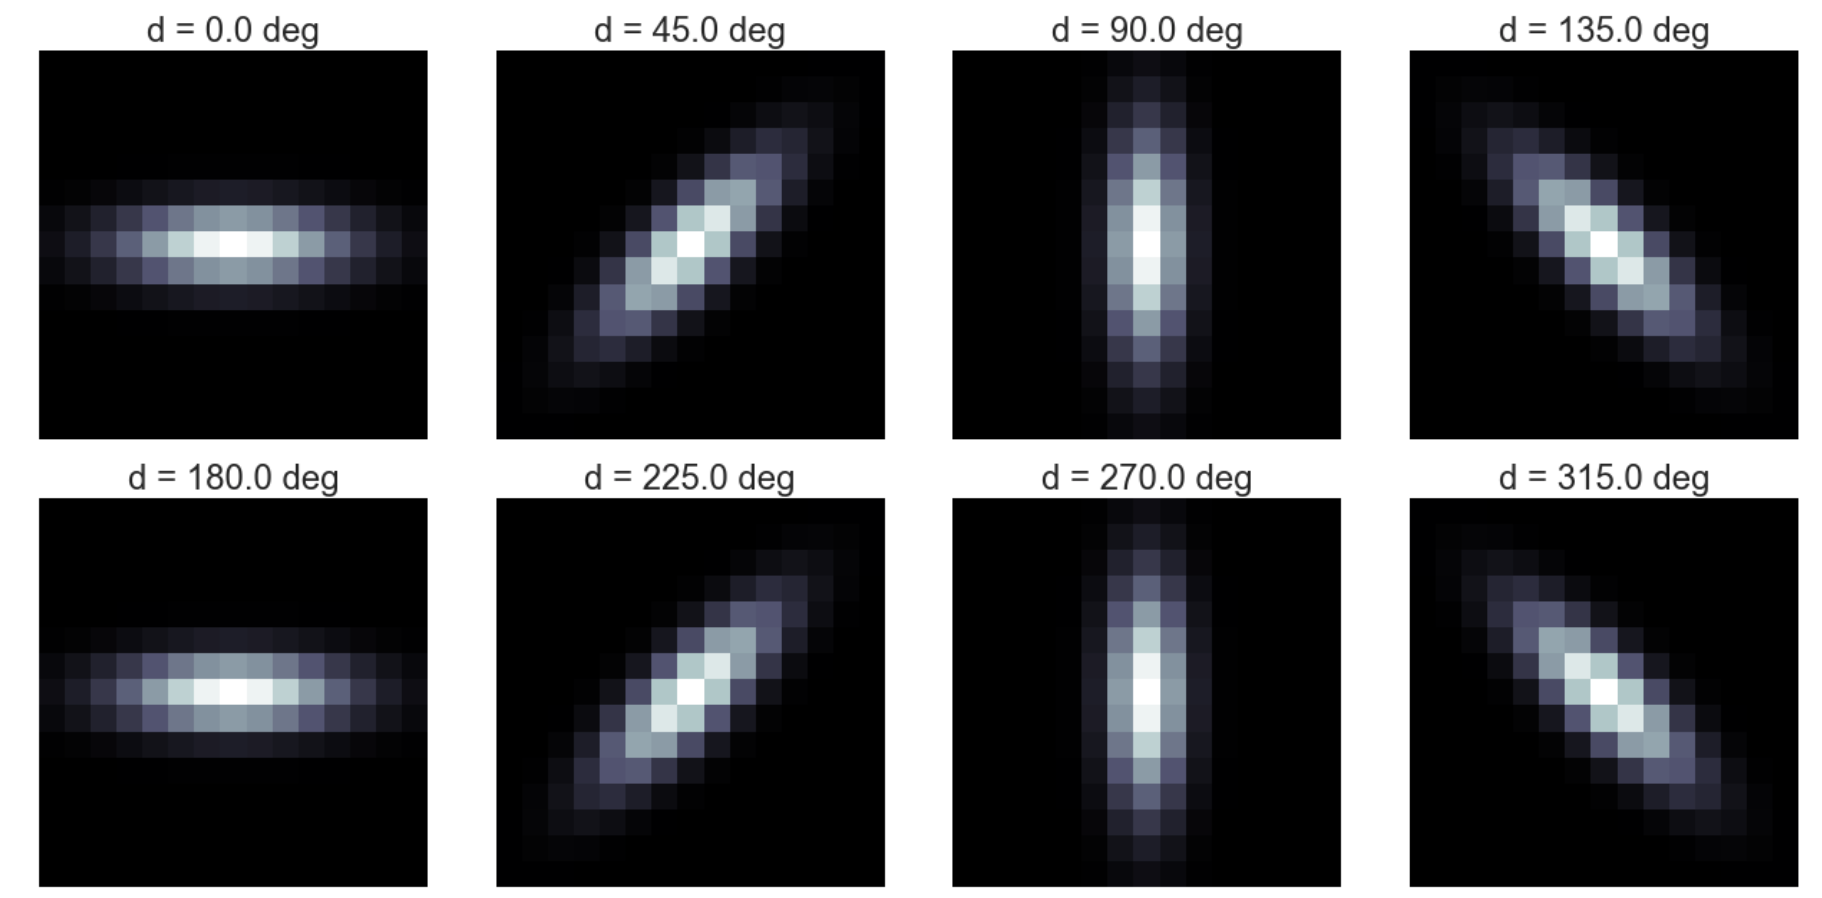

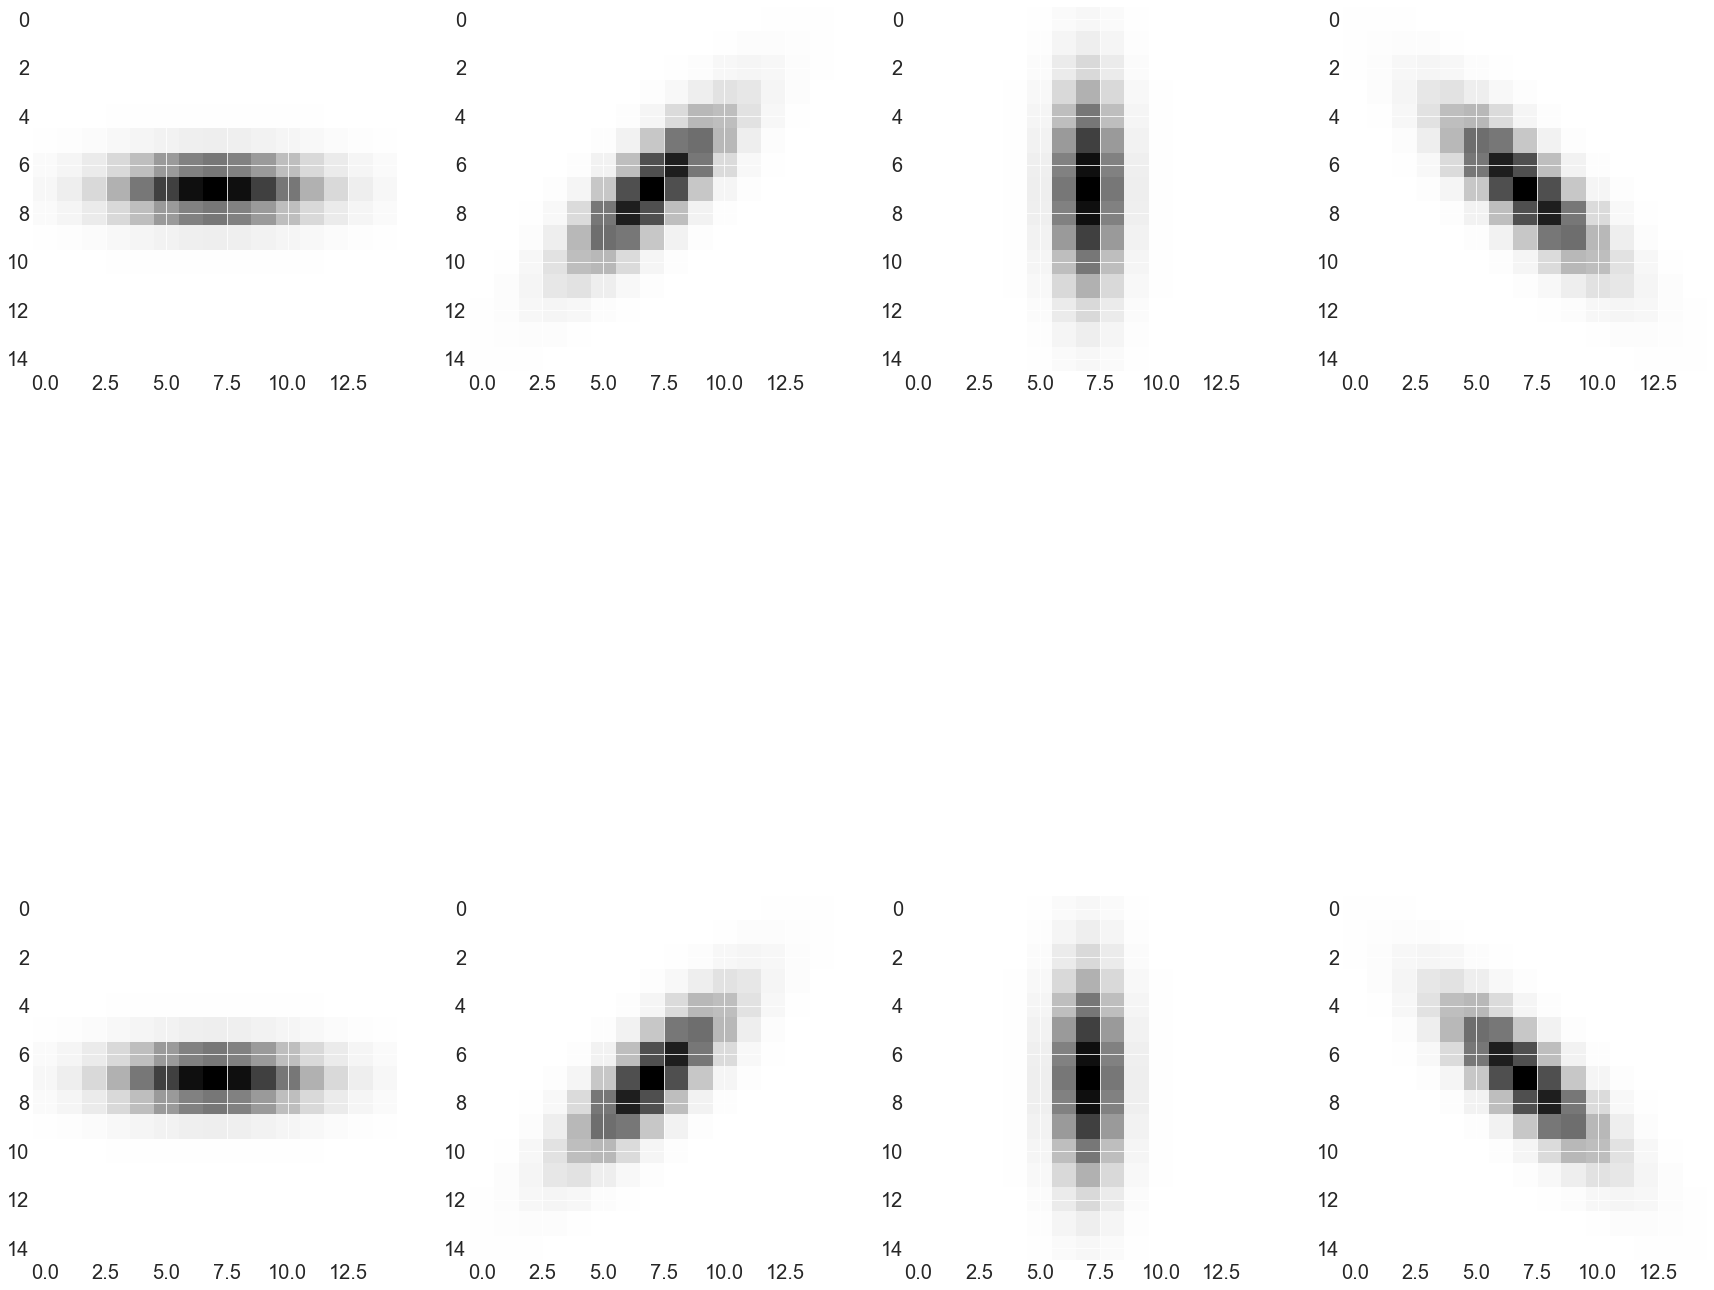

In [56]:
fig, axs = plt.subplots(2, 4, figsize=(30,30))
for i in range(2):
    for j in range(4):
        g = filters.aniso_gauss(i*4+j)
        axs[i, j].imshow(g)